# $n$-Particle Entanglement vs n for N = 12

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as π

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.reload_library()

from collections import defaultdict
from scipy.special import binom
import pickle

import include.colors as colortools

### Load useful utilities from disk

In [2]:
import quenchutils as quench

## Load ED data from disk 

In the ED code, times are measured in units of inverse hopping, i.e. we measure $\overline{t} = t J$.  We need to convert to the dimensionless time used for the Luttinger liquid which is measured in units of $a/v$, i.e. $v t / a$.  This is accomplished using the fact that from the Bethe Ansatz of the $J-V$ model we know:

\begin{equation}
\frac{v}{J a} = \frac{\pi}{2} \frac{\sqrt{1-(V/2)^2}}{\cos^{-1}(V/2)} 
\end{equation}

thus:

\begin{align*}
\frac{v t}{a} &= \frac{v}{J a}\, t J  \newline
& = (J t) \, \frac{\pi}{2} \frac{\sqrt{1-(V/2)^2}}{\cos^{-1}(V/2)}
\end{align*}

We can thus multiply our ED timescale by $\frac{\pi}{2} \frac{\sqrt{1-(V/2)^2}}{\cos^{-1}(V/2)}$.

In [3]:
EDp_n = {}

Vi = 0.0
Vf = [-0.5,-0.25,-0.15,0.15,0.25,0.765]
Δt = 0.1
ti = 0.0
tf = 100.0

N = np.array([12])
n = np.array([cn for cn in range(1,int(N/2)+1)])
colors = colortools.get_linear_colors('Spectral',len(Vf),reverse=False)

for cVf in Vf:
    for i,cN in enumerate(N):
        for cn in n:
            for bc in ['PBC']:
                data_dir = '../data/quench/ED/{:s}/'.format(bc)
                try:
                    p_data = np.loadtxt(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir))
                    EDp_n[quench.lookup(cN,Vi,cVf,Δt,cn,bc=bc)] = p_data
                except:
                    print("Can't load: {:s}".format(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir)))

## Plot Raw Time Evolution

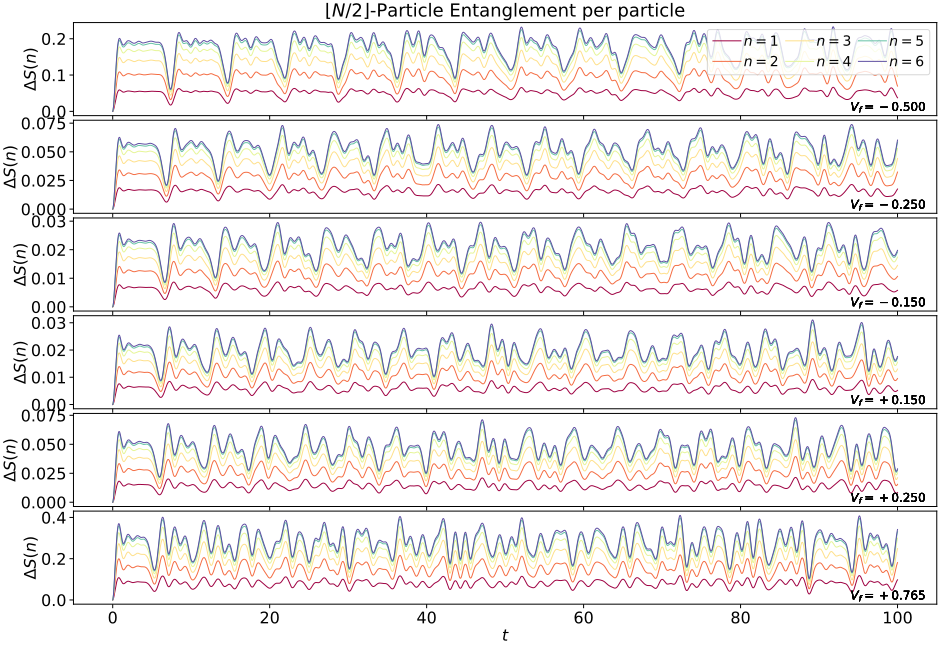

In [4]:
from scipy.interpolate import interp1d

with plt.style.context('./include/notebook.mplstyle'):
    fig, axes = plt.subplots(len(Vf),1,sharex=True, sharey=False, squeeze=True, figsize=(15,10.5))
    fig.subplots_adjust(hspace=0.05)

    cN = 12
    for iV,cVf in enumerate(Vf):
        for i,cn in enumerate(n):
            key = quench.lookup(cN,Vi,cVf,Δt,cn)
            if key in EDp_n:
                label = f'$n = {cn}$'
                x = np.linspace(EDp_n[key][0,0],EDp_n[key][-1,0],10000)
                y = interp1d(EDp_n[key][:,0], EDp_n[key][:,1], kind='cubic')
                axes[iV].plot(x,y(x),marker='None', color=colors[i], 
                              linewidth=1, mew=0, label=label, ms=3)

                axes[iV].set_ylabel('$\Delta S(n)$')
                axes[iV].text(0.9,0.05,'$V_f = {:+5.3f}$'.format(cVf),transform=axes[iV].transAxes, fontsize=12)

    axes[0].legend(frameon=True, loc='upper right',ncol=3, handletextpad=0.2, columnspacing=0.5)
    axes[0].set_title(r'$\lfloor N/2 \rfloor$-Particle Entanglement per particle')
    axes[-1].set_xlabel('$t$');
    #plt.xlim(0,10);

    #plt.savefig('../figures/DeltaSn_vs_t_ED.svg')

### Extract the large time asymptotic value


In [6]:
An_asymp, ΔAn_asymp = defaultdict(list),defaultdict(list)

cN = 12
for iV,cVf in enumerate(Vf):
    vkey = quench.vkey(cVf)
    
    for cn in n: 
        key = quench.lookup(cN,Vi,cVf,Δt,cn,bc='PBC')

        if key in EDp_n:

            # this is the recurrence time predicted by LL theory
            idx = 2*np.where(np.abs(EDp_n[key][:,0]*quench.tscalefactor(cVf)-0.5*cN)<Δt*quench.tscalefactor(cVf))[0][0]

            cdata = EDp_n[key][idx:,1]
            An_asymp[vkey].append(np.average(cdata))
            nb,Δ,ΔAn = quench.binning_error(cdata)
            ΔAn_asymp[vkey].append(ΔAn)
                
    An_asymp[vkey] = np.array(An_asymp[vkey])
    ΔAn_asymp[vkey] = np.array(ΔAn_asymp[vkey])
    
# save them to disk
with open('../figures/ED_Sn.pickle', 'wb') as pfile:
    pickle.dump([n,An_asymp,ΔAn_asymp], pfile, pickle.HIGHEST_PROTOCOL)

## Plot the Results

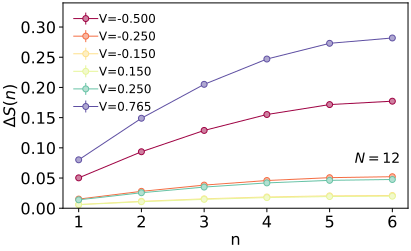

In [7]:
with plt.style.context('./include/notebook.mplstyle'):
    plt.figure()

    presentation = True

    cN = 12
    for iV,cVf in enumerate(Vf):

        props = {'mec':colors[iV],'mew':1.0, 'ecolor':colors[iV], 'elinewidth':1.0, 'ls':'-','ms':6,
                 'mfc':colortools.get_alpha_hex(colors[iV],0.5), 'color':colors[iV], 'lw':1.0}
        vkey = quench.vkey(cVf)

        try:
            plt.errorbar(n,An_asymp[vkey],yerr=ΔAn_asymp[vkey], marker='o',label=vkey, **props)
        except:
            pass


    plt.text(5.4,0.075,f'$N = {cN}$', fontsize=14)
    plt.xlabel('n')
    plt.ylabel(r'$\Delta S(n)$')
    plt.ylim(0,0.34)
    plt.legend(loc='upper left',frameon=False, fontsize=12, handletextpad=0.1)

    #plt.savefig('../figures/deltaS_vs_n_N_12.svg')